In [4]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from model import CalibratableModelFactory
from plotting import (plot_calibration_curve,
                      plot_calibration_details_for_models,
                      plot_fitted_calibrator, plot_sample,
                      plot_sample_predictions)

In [5]:
from datasets import load_dataset

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Data

The data we'll use is a <a href='https://www.openml.org/d/554'>flatten version of the MNIST database</a>.

In [3]:
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

/home/markussagen/.pyenv/versions/model_calibration/lib/python3.8/site-packages/sklearn/datasets/_openml.py:65: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


We'll make the dataset suitable for binary classification by simplifying it into even vs. odd classification. We'll mark even numbers as `positive` and odd ones as `negative`.

In [4]:
positive_idx = y_full.astype(np.int32)%2==0
negative_idx = np.invert(positive_idx)

X_positive, y_positive = X_full[positive_idx], y_full[positive_idx]
X_negative, y_negative = X_full[negative_idx], y_full[negative_idx]

print(f'Number of positive examples: {len(X_positive)}')
print(f'Number of negative examples: {len(X_negative)}')

Number of positive examples: 34418
Number of negative examples: 35582


We can see that the positive subset is a bit more numerous. We'll balance the sets by randomly discarding surplus negative examples.

In [5]:
permutation = np.random.permutation(len(X_negative))[:len(X_positive)]
X_negative, y_negative = X_negative[permutation], y_negative[permutation]

Let's look at the distribution of numbers in the two subsets. We can see that the sets are now balanced, and the individual numbers are represented more-or-less equally. We'll leave it as is, without balancing the data any further.

In [6]:
print(f'Number of positive examples: {len(X_positive)}')
print(f'Number of negative examples: {len(X_negative)}')
print(Counter(y_positive).most_common())
print(Counter(y_negative).most_common())

Number of positive examples: 34418
Number of negative examples: 34418
[('2', 6990), ('0', 6903), ('6', 6876), ('8', 6825), ('4', 6824)]
[('1', 7651), ('7', 7055), ('3', 6920), ('9', 6709), ('5', 6083)]


As a next step, we'll convert the dataset into its final binary form by labeling even numbers with `1` and odd ones with `0`. We merge the two subsets and shuffle the final result.

In [7]:
X = np.concatenate((X_positive, X_negative))
y = np.concatenate((np.ones(len(X_positive)), np.zeros(len(X_negative))))
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

Let's display some random samples from both positive and negative classes to gain more insight and verify no error was introduced along the preprocessing pipeline. 

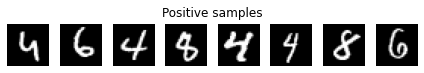

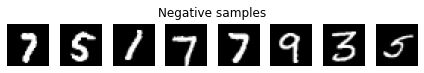

In [8]:
plot_sample(X_positive, "Positive samples")
plt.show()
plot_sample(X_negative, "Negative samples")
plt.show()

Everything looks good. Now, let's go into dividing the dataset into train, test, and calibration sets. The train/test set is a typical one - we want to have separate sets for training and evaluating our solution. When performing calibration, a good practice is to do it on a separate set as well, although sometimes it's done on the test set instead.

We'll take 80% of the data for training, 10% for testing, and 10% for calibration.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8)
X_valid, X_calib, y_valid, y_calib = train_test_split(X_valid, y_valid, train_size=0.5)

print(f"Train length: {len(X_train)}")
print(f"Valid length: {len(X_valid)}")
print(f"Calib length: {len(X_calib)}")

Train length: 55068
Valid length: 6884
Calib length: 6884


Before training, we'll scale the data using `StandardScaler` from `scikit-learn`.This will standardize the features in the data so that it has zero mean and unit variance. Standarization is required for models to train correctly by assuring that each feature contributes to the process in the same way, regardless of its scale.

The scaler is fitted using the training set only, and the same transformations are then applied for all three sets.

In [10]:
X_valid_unscaled = np.copy(X_valid)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_calib = scaler.transform(X_calib)

# Training and calibration

Let's define the models.

We'll create a custom Keras model and four default models, two from sklearn:
- `LogisticRegression` 
- `RandomForestClassifier`

and two from H2O:
- `H2ONaiveBayesEstimator`
- `H2ODeepLearningEstimator`

First, the custom Keras model. It's a simple with two hidden layers with 128 neurons each and ReLU as the activation function. Dropout is used as a regularization method.

In [13]:
"""
keras_nn = Sequential([
    Input(shape=(len(X_train[0], ))),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
keras_nn.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=['binary_accuracy'])
"""

from datasets import load_dataset

from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer


def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# MODEL_NAME = "bert-base-uncased"
MODEL_NAME = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Data
imdb = load_dataset("imdb")
tokenized_imdb = imdb.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Train
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=1, 
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/markussagen/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/markussagen/.cache/huggingface/tr

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
## TF Train
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")


tf_train_dataset = tokenized_imdb["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_imdb["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

from transformers import create_optimizer
import tensorflow as tf

batch_size = 8
num_epochs = 2
batches_per_epoch = len(tokenized_imdb["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)


keras_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


import tensorflow as tf

keras_model.compile(optimizer=optimizer)

keras_model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/markussagen/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/tf_model.h5 from cache at /home/markussagen/.cache/huggingface/transfor

Epoch 1/2
 553/1562 [=========>....................] - ETA: 2:35:00 - loss: 0.3164

Now, let's define the rest of the models. We'll stick to the defaults for all of them, as the aim is not to ge the best performing models possible but merely study their calibration.

In [ ]:
factory = CalibratableModelFactory()
lr = factory.get_model(LogisticRegression())
rf = factory.get_model(RandomForestClassifier())
k_nn = factory.get_model(keras_nn)
keras_model_ = factory.get_model(keras_model)

# models = [lr, rf, k_nn]
models = [keras_model_]

As the next step, we'll train each model on the same training data and check their accuracy on the test set. We won't care about the performance too much, the part we care the most about is the distribution of predictions.

In [ ]:
# split the datasets into 
X_train, y_train = tf_train_dataset[:80%], tf_validation_dataset[:80%]
X_valid, y_valid = tf_train_dataset[80%:90%], tf_validation_dataset[80%:90%]
X_calib, y_calib = tf_train_dataset[90%:], tf_validation_dataset[90%:]

In [ ]:
for model in models:
    model.train(X_train, y_train)
    accuracy = model.score(X_valid, y_valid)
    print(f'{model.name} accuracy: {round(100*accuracy, 2)}%')

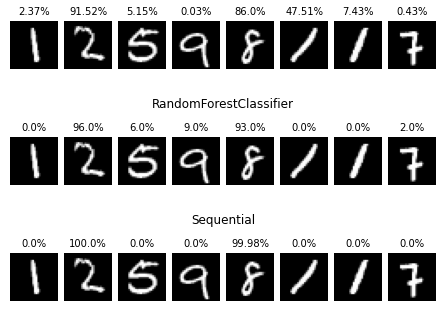

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8)
X_valid, X_calib, y_valid, y_calib = train_test_split(X_valid, y_valid, train_size=0.5)

#plot_sample_predictions(models, X_valid, X_valid_unscaled)
#plt.show()

Before calibrating the models, let's look at their current calibration metrics. This is done on a separate calibration set.

Finally, let's calibrate each model on the calibration set. The `calibrate` method will perform both sigmoid and isotonic calibration.

In [23]:
for model in models:
    model.calibrate(X_calib, y_calib)

Calibration plots for all model:

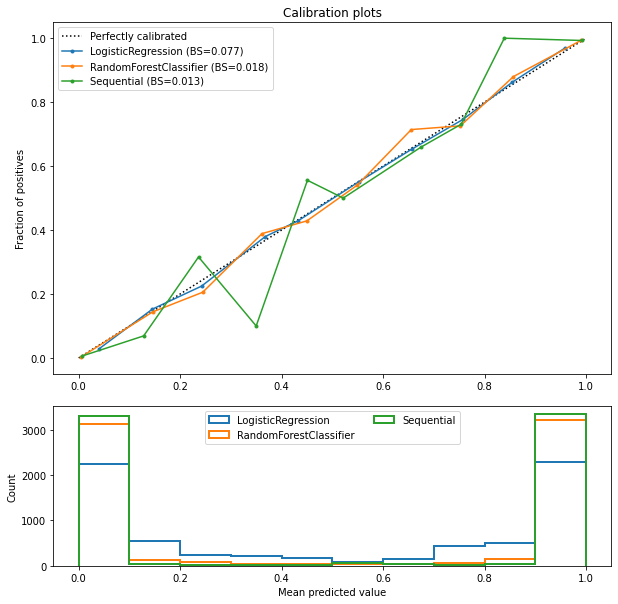

In [24]:
plot_calibration_details_for_models(models, X_calib, y_calib, calibrated=True)
plt.show()

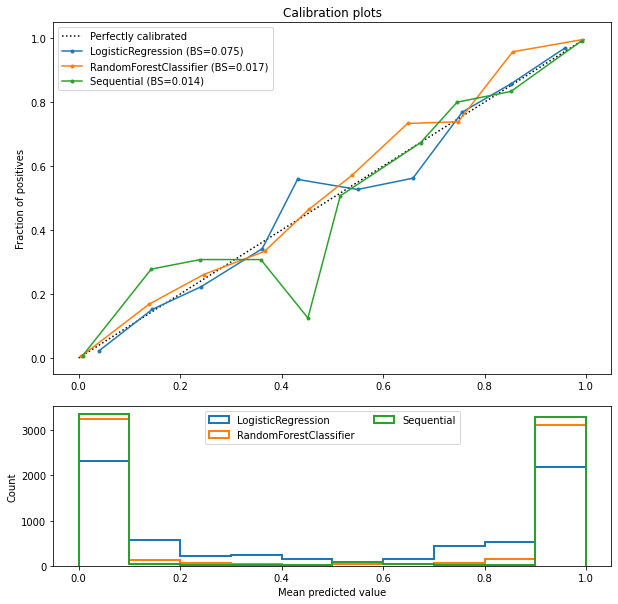

In [25]:
plot_calibration_details_for_models(models, X_valid, y_valid, calibrated=True)
plt.show()

Plots for individual models.

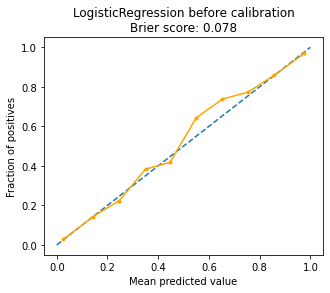

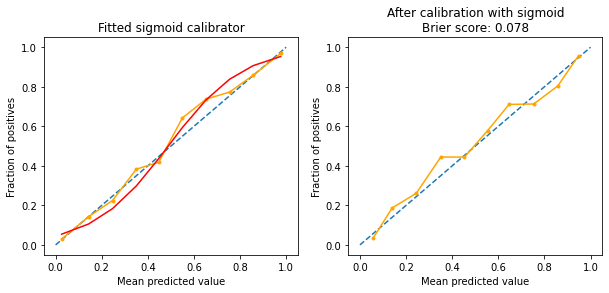

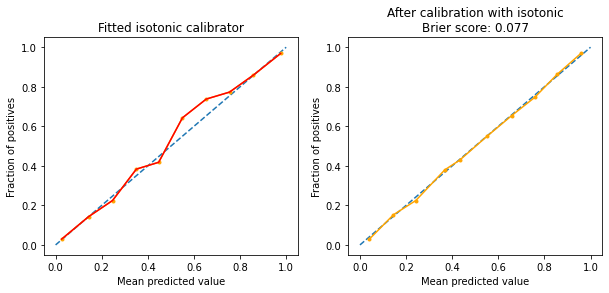

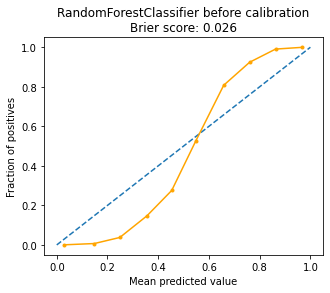

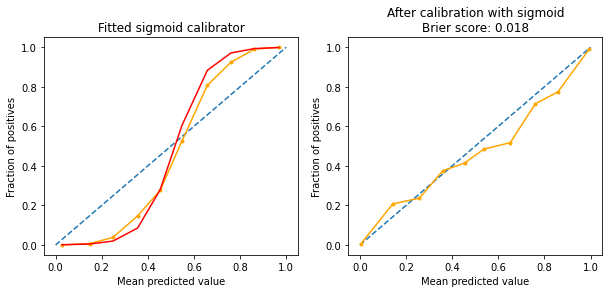

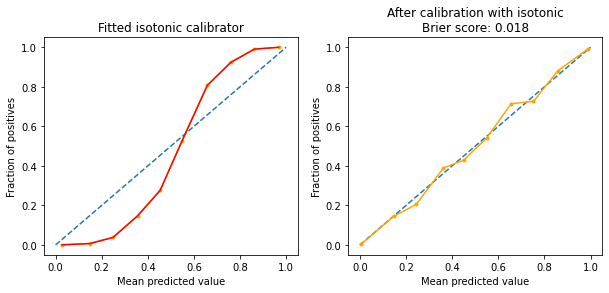

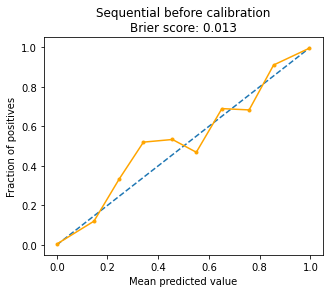

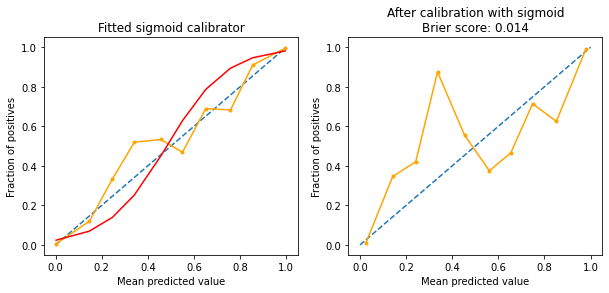

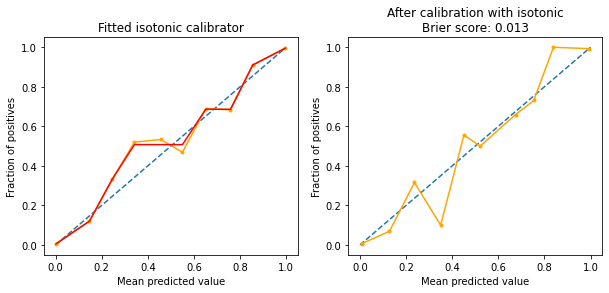

In [26]:
for model in models: 
    plt.figure(figsize=(5, 4))
    prob_true, prob_pred = plot_calibration_curve(y_calib, model.predict(X_calib), f'{model.name} before calibration')
    plt.show()
    for method in ['sigmoid', 'isotonic']:
        plt.figure(figsize=(10, 4))
        plt.subplot(1,2,1)
        plot_fitted_calibrator(prob_true, prob_pred, model.calibrate_probabilities(prob_pred, method), f'Fitted {method} calibrator')
        plt.subplot(1,2,2)
        plot_calibration_curve(y_calib, model.predict_calibrated(X_calib, method), f'After calibration with {method}')
        plt.show()

As the final step, we'll check how calibration affected the performance of our models. It is entirely possible that the measured accuracy will change, but the difference should not be too drastic in much cases.

In [27]:
for model in models:
    accuracy = model.score(X_valid, y_valid)
    print(model.name)
    print(f'Accuracy: {round(100*accuracy, 2)}%')
    for method in ['sigmoid', 'isotonic']:
        accuracy = model.score_calibrated(X_valid, y_valid, method)
        print(f'Accuracy after {method}: {round(100*accuracy, 2)}%')
    print()

LogisticRegression
Accuracy: 89.73%
Accuracy after sigmoid: 89.76%
Accuracy after isotonic: 89.77%

RandomForestClassifier
Accuracy: 97.78%
Accuracy after sigmoid: 97.75%
Accuracy after isotonic: 97.85%

Sequential
Accuracy: 98.17%
Accuracy after sigmoid: 98.16%
Accuracy after isotonic: 98.14%

